## Summary 

* Due to Demonetization, the society had to move to alternate payment modes which included mobile payments, money transfer mechanisms. 
* However at the time of demonetization, only a very handful of companies had mobile based payment applications, and only banks didn't have a well oiled money transfer mechnanisms
* However Debit & Credit payment modes were already an established method of transacting, this study tends to analyze the impact of the demonetization on these payment modes 
* This ipython notebook is only for Debit POS usage
* Forecasting Analysis has been used to find out the values of the ATM & POS transaction amount value for Debit & Cards, had Demonetization **NOT** happened. 
* Comparison of Forecasted Vs Actual values for the Debit & ATM cards was performed

## Debit Card - POS Usage Analysis

> ** Had Demonetization not happened, what would have been the calculated growth **

> **It could be found out that approximately Debit POS usage has increased by 17000 crores a month after demonetization **

### Imports, Constants, Parameter Settings

In [1]:
### Constants & Imports
import bs4
from bs4 import BeautifulSoup
import requests
import urllib
import urllib3
import re
import os
import wget
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import itertools
from dateutil.relativedelta import relativedelta
import numpy as np
#DATA_PATH = "/Users/apple/Gdrive/Term1/PRAT/ATMPOS/"
#OUT_PATH = "/Users/apple/Gdrive/Term1/PRAT/"
DATA_PATH='D:/iCloudDrive/ISB/Term1/PRAT/ATMPOS/'
DATA_TEMP_PATH='D:/TEMP/'
OUT_PATH='D:/iCloudDrive/ISB/Term1/PRAT/'
warnings.filterwarnings("ignore")


### Data Collection:
* Data Collection was performed in an **automated** fashion from RBI website (https://www.rbi.org.in/scripts/atmview.aspx) 
* Packages used: **requests**, **BeautifulSoup**, **wget** packages 
* Data was collected from **Apr 2011** till **Mar 2018**
* All the excel files were stored in a folder path
* Challenges faced:
    + Document format was XLS and XLSX, had to get the right format from the URL

In [6]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.79 Safari/537.36'}

for hdnYear in range(2011,2019):
        for hdnMonth in range(1,13):
            t = requests.post('https://www.rbi.org.in/scripts/atmview.aspx',
                        data={"__EVENTTARGET":"",  
                              "__EVENTARGUMENT": "",
                              "__VIEWSTATE": "/wEPDwUJNTk4NTg1MjM1ZGSKPLK6GXW82/ji/EAmldaxJ0hIqA==",
                              "__VIEWSTATEGENERATOR": "A2040FBE",
                              "__EVENTVALIDATION":"/wEdAAiBl8xNioCmqh1ImqhNQJtslK+XrsQEVyjeDxQ0A4GYXFBwzdjZXczwplb2HKGyLlqLrBfuDtX7nV3nL+5njT0xZDpy7WJnvc3tgXY08CYLJD+rfdwJAuBoVBISURIXWlx9xf1loRXvygROM/A1O+NHJounKCGGAHd04zzVhBPZz/vVliZA8zCb7qOGUcQWjLDx1Mqz",
                              "hdnYear": hdnYear,
                              "hdnMonth": hdnMonth
                        })
            t1 = BeautifulSoup(t.content.lower(),"lxml").find_all("a",href=re.compile(".XLS",re.IGNORECASE))
            for x in t1:
                url = x['href']
                url = url.replace('http://','https://')
                extn = url.split(".")
                f_name = os.path.join(str(DATA_TEMP_PATH),"ATM_POS" +"_" + str(hdnYear) + "_" + str(hdnMonth)+"."+str(extn[-1]))
                wget.download(url,f_name)


### Data Processing:
* An automated tool was developed to extract all the ATM/POS grand totals for Debit & Credit Cards from the excel documents
* All the collected data was stored in the form of dataframe & an output CSV file for further references
* Challenges faced:
    + Data format was not consistent for a few documents
        + Certain documents had multiple sheets
        + Additional text/legends were added
        + Data was not always starting at the same positions
        + Cells were merged in some docs, and it was not at some places
    + Few instances,where certain docs had multiple sheets - manually the excels (~3 documents) had to be manually cleansed. Otherwise the documents were automatically handled

In [2]:
os.chdir(DATA_PATH)
i=0
files = os.listdir()
df2 = pd.DataFrame(columns=['Date', 'pos_cc', 'atm_cc', 'pos_dc', 'atm_dc'])
for file_name in files:
    xl = pd.ExcelFile(file_name)
    sheet1=xl.sheet_names
    df1 = xl.parse(sheet1[0])
    if pd.isna(str(df1.iloc[0,0])) & pd.isna(str(df1.iloc[0,1])):
        df1.drop(df.index[0])
        print('Deleted')
    if pd.isna(str(df1.iloc[0,2])):
        x = 2
    else:
        x = 1
    if 'Amount' in str(df1.iloc[x,10]):
        tot_index = 2
        pos_cc = 11
        atm_cc = 10
        pos_dc = 16
        atm_dc = 15
    else:
        tot_index = 1
        pos_cc = 10
        atm_cc = 9
        pos_dc = 15
        atm_dc = 14
    for index, row in df1.iterrows():
        if 'Total' in str(df1.iloc[index,tot_index]):
            if df1.iloc[index,pos_cc]>0:
                month=file_name.split('_')[3].split('.')[0]
                year=file_name.split('_')[2]
                date1=datetime.date(year=int(year),month=int(month),day=int('01'))
                df2.loc[i] = [date1,df1.iloc[index,pos_cc],df1.iloc[index,atm_cc],df1.iloc[index,pos_dc],df1.iloc[index,atm_dc]]
    i=i+1
df2 = df2.sort_values(by='Date')
f_name= os.path.join(str(OUT_PATH),"Output.xlsx")
writer=pd.ExcelWriter(f_name,date_format='dd mm yyyy',options={'remove_timezone': True})
df2.to_excel(writer,"Sheet1")

### Visualizing the Data & Initial Analysis
* In this document, analysis of Debit Cards - POS Transaction Volumne was **only** performed
* Visually it could be observed that after the demonetization, there is a big spike in the usage of the Debit Cards at POS
* From the graph it could be observed clearly, there is a different trend followed BEFORE & AFTER demonetization.

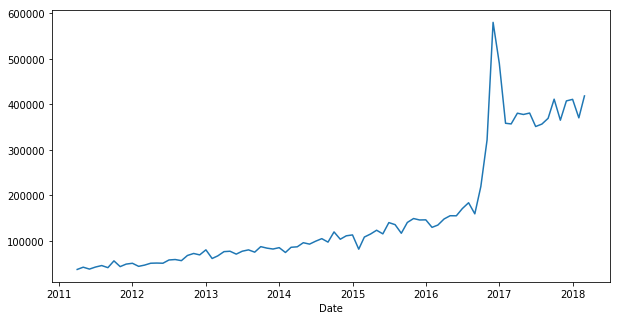

In [8]:
temp = df2
#temp.set_index(['Date'],inplace=True)
temp['pos_dc'].plot(figsize=(10,5))

### Decomposition of the trend
* As given in the problem statement, the forecasting value of the POS Debit Card value, had demonetization NOT happened had to be found out
* Hence the model (seasonal decomposition, ARIMA model) for the period before decomposition would be performed

#### Data has been sub-setted till October to find the trend, seasonality, level 

* Prior to demonetization, there is a clear **linear** and **seasonality** trend
* Residuals do **NOT** have any trend which is good

In [27]:
#df2.index.values
df3=df2[df2['Date'] < datetime.date(int('2016'),int('10'),int('30'))]
df3=df3.set_index(pd.DatetimeIndex(df3['Date']))
decomposition = seasonal_decompose(df3['pos_dc'],freq=12)  

In [28]:
df2.set_index(['Date'],inplace=True)

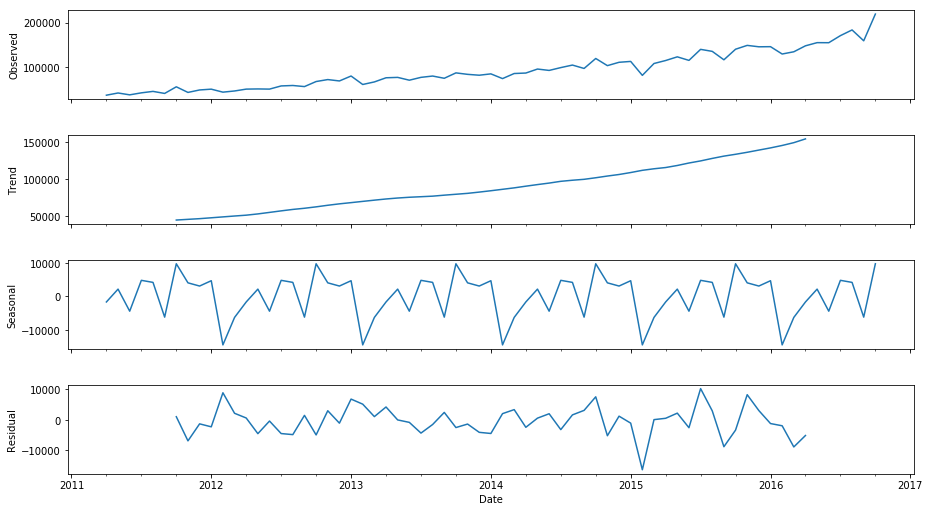

In [29]:
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

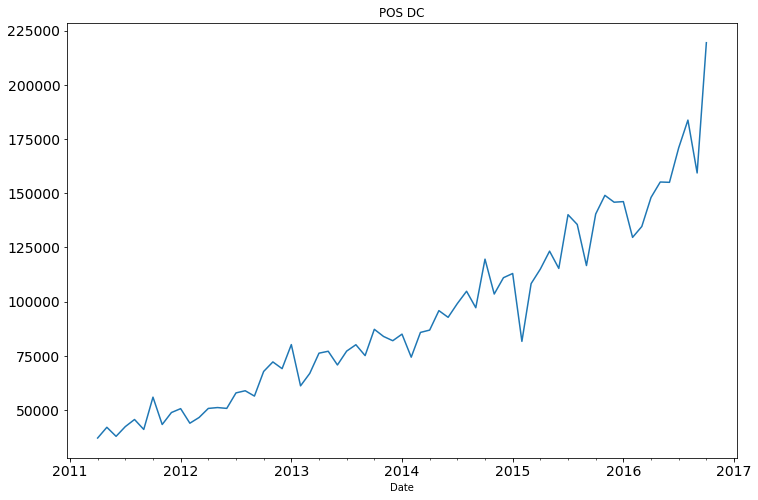

In [30]:
df3.pos_dc.plot(figsize=(12,8), title= 'POS DC', fontsize=14)

#### ARIMA modelling
* To find the right (pdq) and seasonal (pdq) model triplets that fit the pre-demonetization trend
    + RMSE & AIC values was calculated for the various pdq,seasonal-pdq combinations
    + RMSE was the least in the combination **(pdq) = (1, 0, 1) seasonal-pdq = (1, 0, 1, 12)**

> Credit: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
>
> Code was customized to include RMSE to find the best fitting (p,d,q) & seasonal (p,d,q) triplets

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt

results_pos_dc = pd.DataFrame(columns=['pdq', 'seasonal_pdq', 'aic', 'rmse'])

index_rad=0

p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df3['pos_dc'],
                                            order=param,trend='n',
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            df3['forecast_pos_dc'] = results.predict(start='2015-10-01',dynamic=True)  
            rmse = sqrt(mean_squared_error(df3['2015-10-01':]['pos_dc'], df3['2015-10-01':]['forecast_pos_dc']))
            print('ARIMA{}x{}12 - AIC:{} - RMSE:{}'.format(param, param_seasonal, results.aic,rmse))
            results_pos_dc.loc[index_rad] = [param,param_seasonal,results.aic,rmse]
            index_rad = index_rad+1
        except:
            print('Is this failing??')
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1711.8724333970724 - RMSE:158342.50266237988
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:27421.70387941434 - RMSE:159346.6120205867
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1262.0838548291254 - RMSE:45202.077055917776
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:985.8715523913633 - RMSE:36869.73577930517
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1165.9329532206325 - RMSE:10750.943391797508
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1153.7527726498147 - RMSE:10705.3639987803
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:955.6493216498478 - RMSE:16670.07008062639
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:911.4442828131037 - RMSE:11866.836768094201
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1643.9955801775118 - RMSE:154464.08901537204
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:25334.185244766322 - RMSE:16949538.3343581
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1214.4578478069793 - RMSE:43233.70096670639
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:941.3206264762808 - RMSE:35657.214281815286
ARIMA(0, 0, 1)x(1, 0, 0, 12)1

In [32]:
results_pos_dc = results_pos_dc.sort_values('rmse')
results_pos_dc.head(5)

,pdq,seasonal_pdq,aic,rmse
45,"(1, 0, 1)","(1, 0, 1, 12)",1123.624238,9786.171347
61,"(1, 1, 1)","(1, 0, 1, 12)",1105.697878,10185.057403
29,"(0, 1, 1)","(1, 0, 1, 12)",1105.428930,10216.381559
37,"(1, 0, 0)","(1, 0, 1, 12)",1157.606750,10274.033947
13,"(0, 0, 1)","(1, 0, 1, 12)",1330.262446,10586.195419


### Model Building
* ARIMA model for the aforementioned combination was developed 
* Forecasting was done for year from Oct-2015 till Oct-2016 i.e. for one year, to confirm if the model fits the actual trend
* It could be observed that from the below graph, the model fits to the forecasting trend well

In [38]:
mod = sm.tsa.statespace.SARIMAX(df3['pos_dc'],
                                order=(1, 0, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

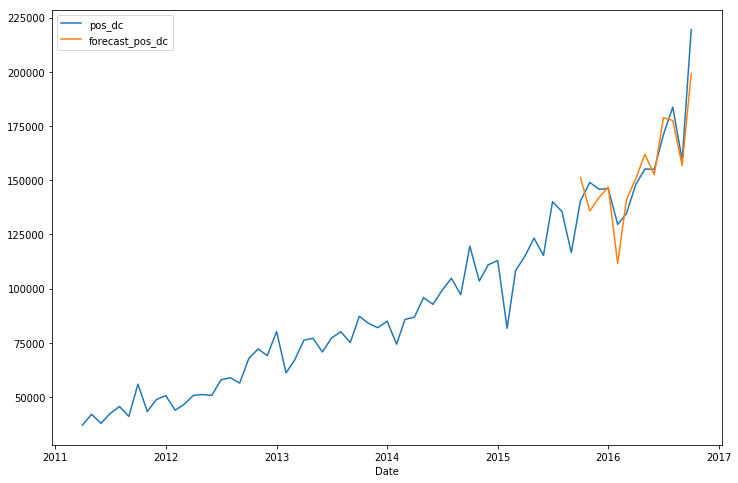

In [57]:
df3['forecast_pos_dc'] = results.predict(start='2015-10-01',end='2016-10-01',dynamic=True)  
df3[['pos_dc', 'forecast_pos_dc']].plot(figsize=(12, 8)) 

### Forecasting for Nov-2016 till Mar-2018

* Forecasting was performed for the given period and plotting was performed
* Plotting confirms the forecasting prediction that was made, can be utilized

In [40]:
start = datetime.datetime.strptime("2016-10-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(1,18)]
future = pd.DataFrame(index=date_list, columns= df3.columns)
dates_list = [datex.date() for datex in date_list]
future['Date'] = dates_list
df4 = pd.concat([df3, future])

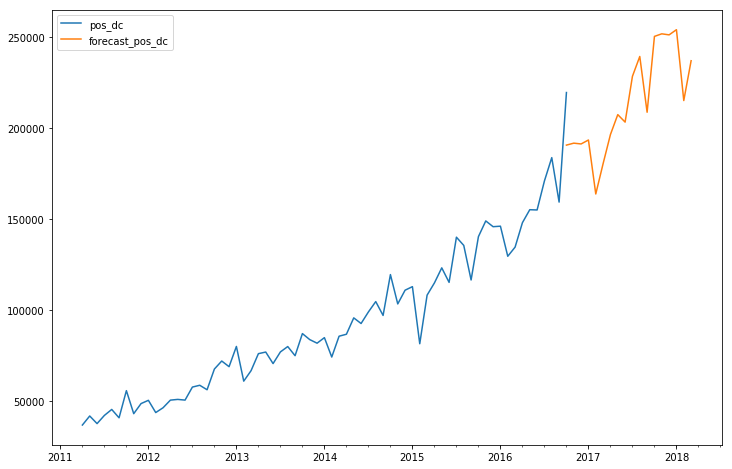

In [41]:
df4['forecast_pos_dc'] = results.predict(start = '2016-10-01', end = '2018-03-01', dynamic= True)  
df4[['pos_dc', 'forecast_pos_dc']].plot(figsize=(12, 8)) 

###  Merging Forecasting & Actual Values
+ A dataset which consists of the forecasted and the actual values for demonetization
+ Very clearly the amount of POS debit transactions have more than doubled
+ On an average per-month the amount of Debit Card POS usage has increased by Rs. 179193 Million per month i.e. Rs. 17919 crore per month

In [42]:
#df4.set_index(['Date'],inplace=True)
for index, row in df4.iterrows():
    #print(df4.loc[index,'forecast_atm_dc'])
    if np.isnan(df4.loc[index,'forecast_pos_dc']):
        df4.loc[index,'forecast_pos_dc'] = df4.loc[index,'pos_dc']

In [43]:
dfx=df2
#dfx.set_index(['Date'],inplace=True)

In [44]:
merge=pd.merge(df2,df4, how='inner', left_index=True, right_index=True)

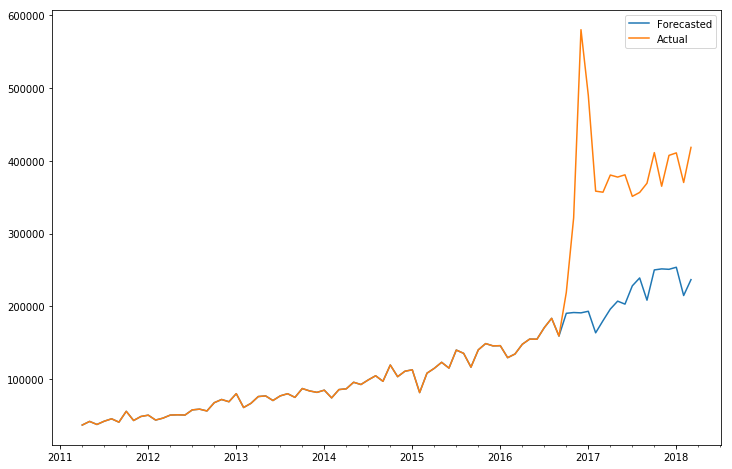

In [45]:

merge['forecast_pos_dc'].plot(figsize=(12, 8),label='Forecasted') 
merge['pos_dc_x'].plot(figsize=(12, 8),label='Actual') 
plt.legend(loc='upper right')
plt.show()


In [47]:
merge['diff'] = merge['pos_dc_x'] - merge['forecast_pos_dc']
merge[merge['diff']!=0]['diff']

2016-10-01     28837.426329
2016-11-01    130097.308721
2016-12-01    389100.737071
2017-01-01    296666.870511
2017-02-01    194662.069707
2017-03-01    176586.793419
2017-04-01    184200.548230
2017-05-01    170482.588732
2017-06-01    177711.511417
2017-07-01    122996.060898
2017-08-01    117469.434115
2017-09-01    160722.770827
2017-10-01    161204.101134
2017-11-01    113588.294738
2017-12-01    156567.805202
2018-01-01    157151.599330
2018-02-01    155356.422170
2018-03-01    181720.439863
Name: diff, dtype: float64

> + ** Average difference between forecasted and actual values ** 

In [60]:
merge[merge['diff']!=0]['diff'][1:].mean()

179193.25624016722